In [ ]:
%matplotlib inline

!pip install qiskit
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 107.3 MB/s eta 0:00:00


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


In [3]:
# ---------- ORACLES ----------
def oracle_constant(qc, ancilla, value=0):
    """Constant oracle: f(x)=0 or f(x)=1"""
    if value == 1:
        qc.x(ancilla)


def oracle_balanced_parity(qc, inputs, ancilla):
    """Balanced oracle: f(x) = x0 XOR x1 XOR ... XOR xn"""
    for q in inputs:
        qc.cx(q, ancilla)




In [4]:
# ---------- DEUTSCH–JOZSA CIRCUIT ----------
def deutsch_jozsa_circuit(n, oracle_func, *oracle_args):
    """
    n: number of input qubits
    oracle_func: oracle function to modify the circuit
    oracle_args: extra arguments for oracle
    """
    qreg = QuantumRegister(n + 1, "q")
    creg = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qreg, creg)

    inputs = list(range(n))
    ancilla = n

    # Step 1: Initialize |0...0>|1>
    qc.x(ancilla)

    # Step 2: Apply Hadamard to all qubits
    qc.h(qreg)

    # Step 3: Oracle
    oracle_func(qc, *oracle_args)

    # Step 4: Apply Hadamard to input qubits
    for q in inputs:
        qc.h(q)

    # Step 5: Measure only input qubits
    qc.measure(inputs, creg)

    return qc


In [5]:
# ---------- EXECUTION ----------
def run_dj(qc):
    """Run Deutsch–Jozsa circuit on AerSimulator"""
    simulator = AerSimulator()
    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    print("Measurement counts:", counts)
    plot_histogram(counts)
    plt.show()

    n = qc.num_clbits
    if counts.get("0" * n, 0) == 1024:
        print("✅ Function is CONSTANT")
    else:
        print("✅ Function is BALANCED")


In [6]:
# ---------- MAIN ----------
if __name__ == "__main__":
    n = 3  # number of input qubits

    print("\n=== Constant Oracle (f(x)=0) ===")
    qc_const = deutsch_jozsa_circuit(
        n, oracle_constant, n, 0
    )
    print(qc_const.draw(fold=-1))
    run_dj(qc_const)

    print("\n=== Balanced Oracle (Parity) ===")
    qc_balanced = deutsch_jozsa_circuit(
        n, oracle_balanced_parity, list(range(n)), n
    )
    print(qc_balanced.draw(fold=-1))
    run_dj(qc_balanced)



=== Constant Oracle (f(x)=0) ===
     ┌───┐┌───┐┌─┐      
q_0: ┤ H ├┤ H ├┤M├──────
     ├───┤├───┤└╥┘┌─┐   
q_1: ┤ H ├┤ H ├─╫─┤M├───
     ├───┤├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├─╫──╫─┤M├
     ├───┤├───┤ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─╫──╫──╫─
     └───┘└───┘ ║  ║  ║ 
c: 3/═══════════╩══╩══╩═
                0  1  2 
Measurement counts: {'000': 1024}
✅ Function is CONSTANT

=== Balanced Oracle (Parity) ===
     ┌───┐          ┌───┐     ┌─┐           
q_0: ┤ H ├───────■──┤ H ├─────┤M├───────────
     ├───┤       │  └───┘┌───┐└╥┘     ┌─┐   
q_1: ┤ H ├───────┼────■──┤ H ├─╫──────┤M├───
     ├───┤       │    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_2: ┤ H ├───────┼────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘└───┘└───┘ ║       ║  ║ 
c: 3/══════════════════════════╩═══════╩══╩═
                               0       1  2 
Measurement counts: {'111': 1024}
✅ Function is BALANCED


In [ ]:
# T1

In [7]:
def oracle_balanced_half(qc, inputs, ancilla):
    qc.cx(inputs[0], ancilla)
    qc.ccx(inputs[1], inputs[2], ancilla)

qc_balanced_half = deutsch_jozsa_circuit(
    3, oracle_balanced_half, list(range(3)), 3
)
run_dj(qc_balanced_half)


Measurement counts: {'011': 272, '111': 276, '101': 250, '001': 226}
✅ Function is BALANCED


In [ ]:
# Task 2

In [8]:
for n in [2, 4, 5]:
    print(f"\n=== Running Deutsch–Jozsa with n={n} ===")
    qc_balanced = deutsch_jozsa_circuit(
        n, oracle_balanced_parity, list(range(n)), n
    )
    print(qc_balanced.draw(fold=-1))
    run_dj(qc_balanced)



=== Running Deutsch–Jozsa with n=2 ===
     ┌───┐          ┌───┐     ┌─┐   
q_0: ┤ H ├───────■──┤ H ├─────┤M├───
     ├───┤       │  └───┘┌───┐└╥┘┌─┐
q_1: ┤ H ├───────┼────■──┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐┌─┴─┐└───┘ ║ └╥┘
q_2: ┤ X ├┤ H ├┤ X ├┤ X ├──────╫──╫─
     └───┘└───┘└───┘└───┘      ║  ║ 
c: 2/══════════════════════════╩══╩═
                               0  1 
Measurement counts: {'11': 1024}
✅ Function is BALANCED

=== Running Deutsch–Jozsa with n=4 ===
     ┌───┐          ┌───┐     ┌─┐                   
q_0: ┤ H ├───────■──┤ H ├─────┤M├───────────────────
     ├───┤       │  └───┘┌───┐└╥┘     ┌─┐           
q_1: ┤ H ├───────┼────■──┤ H ├─╫──────┤M├───────────
     ├───┤       │    │  └───┘ ║ ┌───┐└╥┘     ┌─┐   
q_2: ┤ H ├───────┼────┼────■───╫─┤ H ├─╫──────┤M├───
     ├───┤       │    │    │   ║ └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────┼────┼────┼───╫───■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐ ║ ┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├─╫─┤ X ├─╫───────╫──╫─
 

In [ ]:
# Task 3

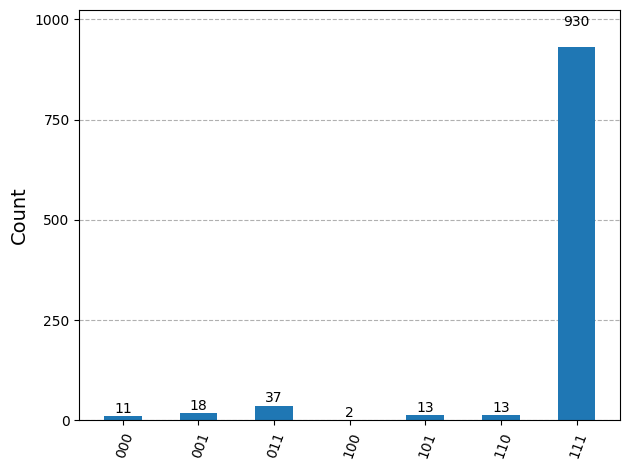

Noisy measurement counts: {'100': 2, '001': 18, '110': 13, '000': 11, '101': 13, '011': 37, '111': 930}


In [9]:
from qiskit_aer.noise import NoiseModel, errors
from qiskit_aer import AerSimulator

# Create a simple custom noise model
noise_model = NoiseModel()
p1_error = 0.01  # 1-qubit depolarizing error probability
p2_error = 0.03  # 2-qubit depolarizing error probability

error_1q = errors.depolarizing_error(p1_error, 1)
error_2q = errors.depolarizing_error(p2_error, 2)

# Apply noise to single- and two-qubit gates
noise_model.add_all_qubit_quantum_error(error_1q, ['x', 'h'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

simulator_noisy = AerSimulator(noise_model=noise_model)

qc_noisy = deutsch_jozsa_circuit(3, oracle_balanced_parity, list(range(3)), 3)
tqc_noisy = transpile(qc_noisy, simulator_noisy)
job_noisy = simulator_noisy.run(tqc_noisy, shots=1024)
result_noisy = job_noisy.result()
counts_noisy = result_noisy.get_counts()
display(plot_histogram(counts_noisy))
print("Noisy measurement counts:", counts_noisy)


In [ ]:
# Task 4

In [10]:
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.4 MB/s eta 0:00:00


In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(token="", overwrite=True)

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit import transpile
from qiskit.visualization import plot_histogram
from IPython.display import display

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print("Running on backend:", backend.name)

qc_real = deutsch_jozsa_circuit(3, oracle_balanced_parity, list(range(3)), 3)
tqc_real = transpile(qc_real, backend=backend, optimization_level=1, translation_method="translator")

sampler = SamplerV2(backend)
job_real = sampler.run([tqc_real])
result_real = job_real.result()

data_block = result_real[0].data
quasi_dist = None
if "quasi_dists" in data_block:
    quasi_dist = data_block["quasi_dists"][0]
elif "samples" in data_block:
    quasi_dist = data_block["samples"][0]
else:
    print("Available keys in result:", list(data_block.keys()))

if quasi_dist:
    display(plot_histogram(quasi_dist))
    print("Real device quasi-probabilities:", quasi_dist)


qiskit_runtime_service.__init__:WARNING:2025-11-04 18:25:33,330: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-04 18:25:33,681: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-04 18:25:35,490: Using instance: open-instance, plan: open


Running on backend: ibm_fez
Available keys in result: ['c']


In [ ]:
# Task 5

In [13]:
qc = QuantumCircuit(4)
inputs = list(range(3))
ancilla = 3
oracle_balanced_parity(qc, inputs, ancilla)

print(qc.to_gate().definition)


                    
q_0: ──■────────────
       │            
q_1: ──┼────■───────
       │    │       
q_2: ──┼────┼────■──
     ┌─┴─┐┌─┴─┐┌─┴─┐
q_3: ┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘
